In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy

# Initial data loading and plotting

### Format for LAKE input data for reference

* N_header_lines* --- the number of lines, occupied by file header 
* N_coloumns*     --- the total number of coloumns in the file
* N_Year*         --- the number of coloumn with the number of year (not used in the model)
* N_Month*        --- the number of coloumn with the number of month (not used in the model)
* N_Day*          --- the number of coloumn with the number of day (not used in the model)
* N_Hour*         --- the number of coloumn with the number of hour (not used in the model)
* N_Uspeed*       --- the number of coloumn with x-component speed values,      (m/s)
* N_Vspeed*       --- the number of coloumn with y-component speed values,      (m/s)
* N_Temp*         --- the number of coloumn with air temperature values,        (K)
* N_Hum*          --- the number of coloumn with air humidity values,           (kg/kg)
* N_Pres*         --- the number of coloumn with atmospheric pressure value,s   (Pa)
* N_SWdown*       --- the number of coloumn with net solar radiation values,    (W/m**2)
* N_LWdown*       --- the number of coloumn with net longwave radiation values, (W/m**2)
* N_Precip*       --- the number of coloumn with precipitation intensity,       (m/s)

In [2]:
#paths to in-situ data
path_to_burned='YKD/in_situ/YKD_burned_gapfilledCO2_2022.xlsx'
path_to_unburned='YKD/in_situ/YKD_unburned_gapfilledCO2_2022.xlsx'

In [3]:
#read excel sheets as dataframes
df_burned = pd.read_excel(path_to_burned)
df_unburned = pd.read_excel(path_to_unburned)

#drop unnecesarry columns
df_burned = df_burned.drop(columns=['Year', 'DoY', 'Hour', 'NEE_f', 'CH4', 'SoilT_f', 'PPFD_f', 'H', 'LE', 'VPD'])
df_unburned =df_unburned.drop(columns=['Year', 'DoY', 'Hour', 'NEE_f', 'CH4', 'SoilT_f', 'PPFD_f', 'H', 'LE', 'VPD'])

#Standardize precip columns
df_burned = df_burned.rename(columns={'Precip':'Precip_mm'})
df_unburned = df_unburned.rename(columns={'Precip (mm)':'Precip_mm'})

#Register timestamps
df_burned['DateTime']=pd.to_datetime(df_burned['DateTime'])
df_unburned['DateTime']=pd.to_datetime(df_unburned['DateTime'])

#Standardize year month day columns
df_burned['Year']=pd.DatetimeIndex(df_burned['DateTime']).year
df_burned['Month']=pd.DatetimeIndex(df_burned['DateTime']).month
df_burned['Day']=pd.DatetimeIndex(df_burned['DateTime']).day
df_burned['hour']=pd.DatetimeIndex(df_burned['DateTime']).hour

df_unburned['Year']=pd.DatetimeIndex(df_unburned['DateTime']).year
df_unburned['Month']=pd.DatetimeIndex(df_unburned['DateTime']).month
df_unburned['Day']=pd.DatetimeIndex(df_unburned['DateTime']).day
df_unburned['hour']=pd.DatetimeIndex(df_unburned['DateTime']).hour

In [4]:
#aggregate all half-hourly measurements to daily by taking the mean, sum precipitation
df_burned_daily = df_burned.groupby(by=['Year', 'Month', 'Day']).aggregate({
                                                                            'Tair_f': 'mean',
                                                                            'RH': 'mean',
                                                                            'Wind_Speed': 'mean',
                                                                            'Wind_Dir': 'mean',
                                                                            'SW_In_f': 'mean',
                                                                            'SW_Out': 'mean',
                                                                            'LW_In': 'mean',
                                                                            'LW_Out': 'mean',
                                                                            'Precip_mm': 'sum',
                                                                            'Air_Pressure': 'mean'
                                                                            }).reset_index()

#aggregate all half-hourly measurements to daily by taking the mean, sum precipitation
df_unburned_daily = df_unburned.groupby(by=['Year', 'Month', 'Day']).aggregate({
                                                                            'Tair_f': 'mean',
                                                                            'RH': 'mean',
                                                                            'Wind_Speed': 'mean',
                                                                            'Wind_Dir': 'mean',
                                                                            'SW_In_f': 'mean',
                                                                            'SW_Out': 'mean',
                                                                            'LW_In': 'mean',
                                                                            'LW_Out': 'mean',
                                                                            'Precip_mm': 'sum',
                                                                            'Air_Pressure': 'mean'
                                                                            }).reset_index()

In [5]:
#datetimes for daily aggregated data
df_burned_daily['datetime']=pd.to_datetime(df_burned_daily[['Year', 'Month', 'Day']])
df_unburned_daily['datetime']=pd.to_datetime(df_unburned_daily[['Year', 'Month', 'Day']])

#Filter negative values from shortwave
df_burned_daily['SW_In_f'] = df_burned_daily['SW_In_f'].where((df_burned_daily['SW_In_f']>0) | (df_burned_daily['SW_In_f'].isnull()), 0)
df_unburned_daily['SW_In_f'] = df_unburned_daily['SW_In_f'].where((df_unburned_daily['SW_In_f']>0) | (df_unburned_daily['SW_In_f'].isnull()), 0)

#last day of unburned air pressure is bad
df_unburned_daily.loc[(df_unburned_daily['Month']==12) & (df_unburned_daily['Day']==31), 'Air_Pressure'] = np.nan

#set rh >= 1 to 0.99
df_burned_daily.loc[df_burned_daily['RH']>=100, 'RH'] = 99
df_unburned_daily.loc[df_unburned_daily['RH']>=100, 'RH'] = 99

def calc_mr(temp, pres, rh):
    """Calculates mixing ratio (kg/kg) based on temp (K), Pressure (Pa), and RH (%)

    Args:
        temp (arraylike, numeric): temperature in Kelvin
        pres (arraylike, numeric): Air pressure in Pa
        rh (arraylike, numeric): Relative humidity in percent

    Returns:
         (arraylike, numeric): mixing ratio (kg water / kg air)
    """ 
    
    temp = temp-273.15
    mr=[]
    
    for i, temp in enumerate(temp):
        if temp>0:
            pws=610.94*np.exp(1)**(17.625*temp/(temp+243.04))
        else:
            pws=611.21*np.exp(1)**(22.587*temp/(temp+273.86))
        
        pw = (pws*rh[i])/100
        
        mr.append(0.62198*pw/(pres[i] - pw))
    return mr

#convert rh from percent to mixing ratio
df_unburned_daily['RH (kg/kg)'] = calc_mr(df_unburned_daily['Tair_f'], df_unburned_daily['Air_Pressure'], df_unburned_daily['RH'])

df_burned_daily['RH (kg/kg)'] = calc_mr(df_burned_daily['Tair_f'], df_burned_daily['Air_Pressure'], df_burned_daily['RH'])


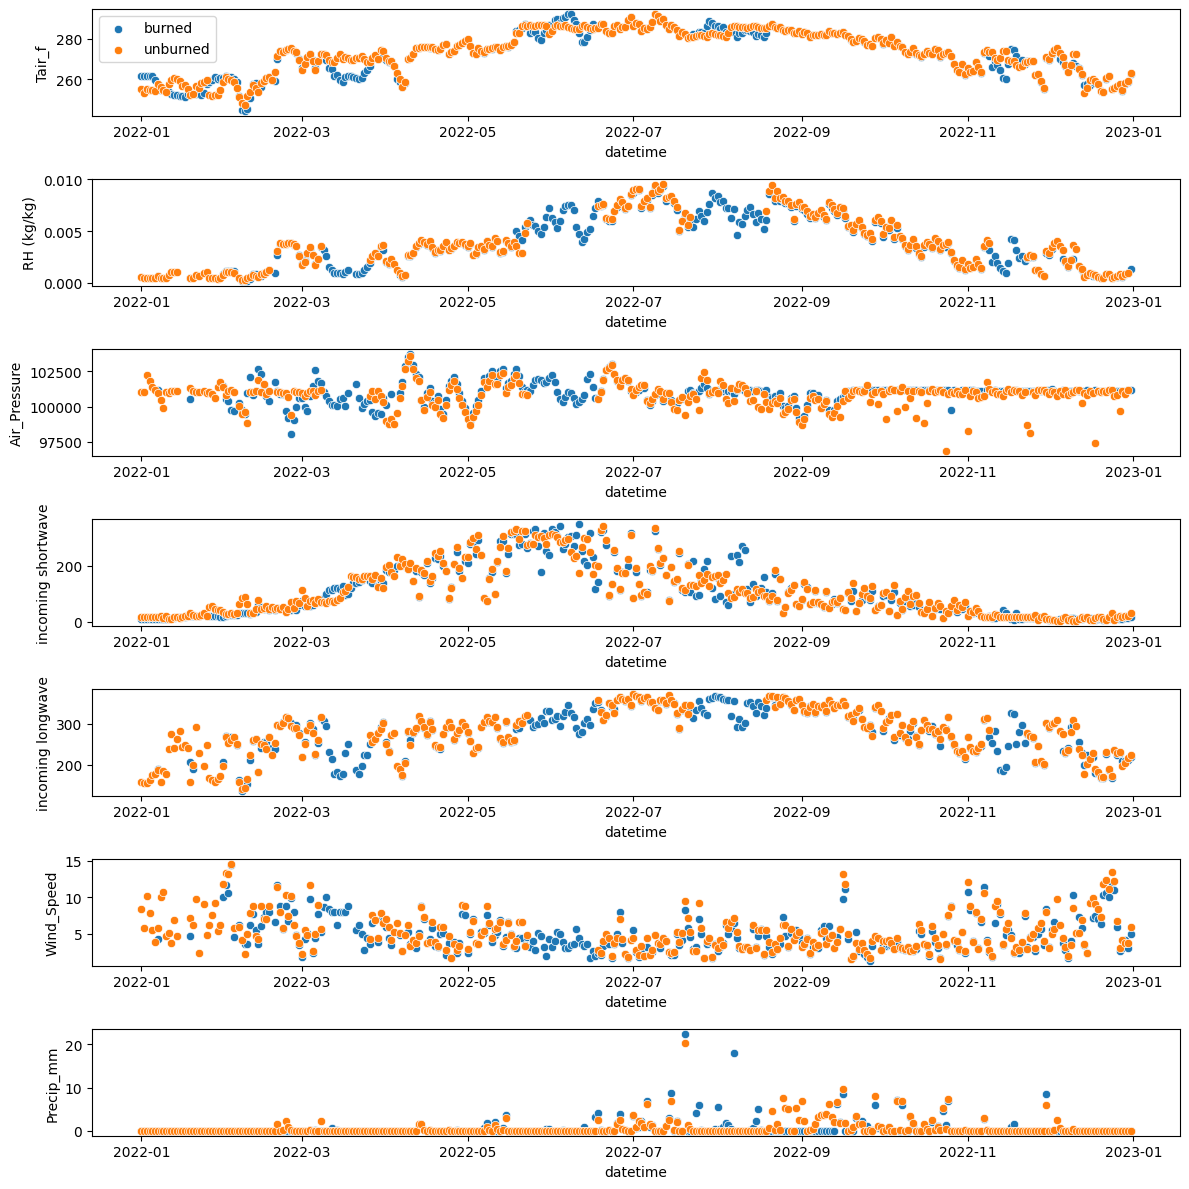

In [6]:
#plot initial data
fig, axes=plt.subplots(7,1, figsize=(12,12))
sns.scatterplot(data=df_burned_daily, x='datetime', y='Tair_f', ax=axes[0], label='burned')
sns.scatterplot(data=df_unburned_daily, x='datetime', y='Tair_f', ax=axes[0], label='unburned')

sns.scatterplot(data=df_burned_daily, x='datetime', y='RH (kg/kg)', ax=axes[1])
sns.scatterplot(data=df_unburned_daily, x='datetime', y='RH (kg/kg)', ax=axes[1])

sns.scatterplot(data=df_burned_daily, x='datetime', y='Air_Pressure', ax=axes[2])
sns.scatterplot(data=df_unburned_daily, x='datetime', y='Air_Pressure', ax=axes[2])

sns.scatterplot(data=df_burned_daily, x='datetime', y=df_burned_daily['SW_In_f'], ax=axes[3])
sns.scatterplot(data=df_unburned_daily, x='datetime', y=df_unburned_daily['SW_In_f'], ax=axes[3])
axes[3].set_ylabel('incoming shortwave')

sns.scatterplot(data=df_burned_daily, x='datetime', y=df_burned_daily['LW_In'], ax=axes[4])
sns.scatterplot(data=df_unburned_daily, x='datetime', y=df_unburned_daily['LW_In'], ax=axes[4])
axes[4].set_ylabel('incoming longwave')

sns.scatterplot(data=df_burned_daily, x='datetime', y='Wind_Speed', ax=axes[5])
sns.scatterplot(data=df_unburned_daily, x='datetime', y='Wind_Speed', ax=axes[5])

sns.scatterplot(data=df_burned_daily, x='datetime', y='Precip_mm', ax=axes[6])
sns.scatterplot(data=df_unburned_daily, x='datetime', y='Precip_mm', ax=axes[6])

fig.tight_layout()


# Gap-filling
We will first gap-fill the burned and unburned towers based on each other's data, with a correction to account for the slight difference between conditions at each tower

In [7]:
#merge the burned and unburned dataframes on datetime
df_daily_merged = df_unburned_daily.merge(df_burned_daily, on='datetime', suffixes=('_unburned', '_burned'))

#drop any rows containing nan for regression
df_daily_merged_nonan = df_daily_merged.dropna(axis=0)

In [8]:
def get_correction_fit(df, from_column, to_column):
    """Applies linear regression bias-correct values from {from_column} to {to_column}

    Args:
        df (pd.DataFrame): dataframe containing columns to correct
        from_column (str): column with data which we wish to apply bias correction
        to_column (str): column with target data distribution

    Returns:
         reg_score (float): r2 score for linear regression
         reg_coef (float): coefficient for bias-correction linear regression
         reg_intercept (float): intercept for bias-correction linear regression
    """ 
    reg = LinearRegression().fit(df[from_column].to_numpy().reshape(-1,1), 
                                  df[to_column].to_numpy().reshape(-1,1))
    reg_score=reg.score(df[from_column].to_numpy().reshape(-1,1), 
                              df[to_column].to_numpy().reshape(-1,1))
    reg_coef=reg.coef_[0]
    reg_intercept=reg.intercept_[0]
    
    return reg_score, reg_coef, reg_intercept

In [9]:
#burned to unburned corrections
b2u_reg_tair_score, b2u_reg_tair_coef, b2u_reg_tair_intercept = get_correction_fit(df_daily_merged_nonan, 'Tair_f_burned', 'Tair_f_unburned')

b2u_reg_rh_score, b2u_reg_rh_coef, b2u_reg_rh_intercept = get_correction_fit(df_daily_merged_nonan, 'RH (kg/kg)_burned', 'RH (kg/kg)_unburned')

#air pressure is noisy so we will just shift the distribution to align the median values
b2u_air_press_median_adjust = np.median(df_daily_merged_nonan['Air_Pressure_burned']) - np.median(df_daily_merged_nonan['Air_Pressure_unburned'])

b2u_reg_sw_net_score, b2u_reg_sw_net_coef, b2u_reg_sw_net_intercept = get_correction_fit(df_daily_merged_nonan, 'SW_In_f_burned', 'SW_In_f_unburned')

b2u_reg_lw_net_score, b2u_reg_lw_net_coef, b2u_reg_lw_net_intercept = get_correction_fit(df_daily_merged_nonan, 'LW_In_burned', 'LW_In_unburned')

b2u_reg_wind_speed_score, b2u_reg_wind_speed_coef, b2u_reg_wind_speed_intercept = get_correction_fit(df_daily_merged_nonan, 'Wind_Speed_burned', 'Wind_Speed_unburned')

#unburned to burned corrections
u2b_reg_tair_score, u2b_reg_tair_coef, u2b_reg_tair_intercept = get_correction_fit(df_daily_merged_nonan, 'Tair_f_unburned', 'Tair_f_burned')

u2b_reg_rh_score, u2b_reg_rh_coef, u2b_reg_rh_intercept = get_correction_fit(df_daily_merged_nonan, 'RH (kg/kg)_unburned', 'RH (kg/kg)_burned')

#air pressure is noisy so we will just shift the distribution to align the median values
u2b_air_press_median_adjust = np.median(df_daily_merged_nonan['Air_Pressure_unburned']) - np.median(df_daily_merged_nonan['Air_Pressure_burned'])

u2b_reg_sw_net_score, u2b_reg_sw_net_coef, u2b_reg_sw_net_intercept = get_correction_fit(df_daily_merged_nonan, 'SW_In_f_unburned', 'SW_In_f_burned')

u2b_reg_lw_net_score, u2b_reg_lw_net_coef, u2b_reg_lw_net_intercept = get_correction_fit(df_daily_merged_nonan, 'LW_In_unburned', 'LW_In_burned')

u2b_reg_wind_speed_score, u2b_reg_wind_speed_coef, u2b_reg_wind_speed_intercept = get_correction_fit(df_daily_merged_nonan, 'Wind_Speed_unburned', 'Wind_Speed_burned')


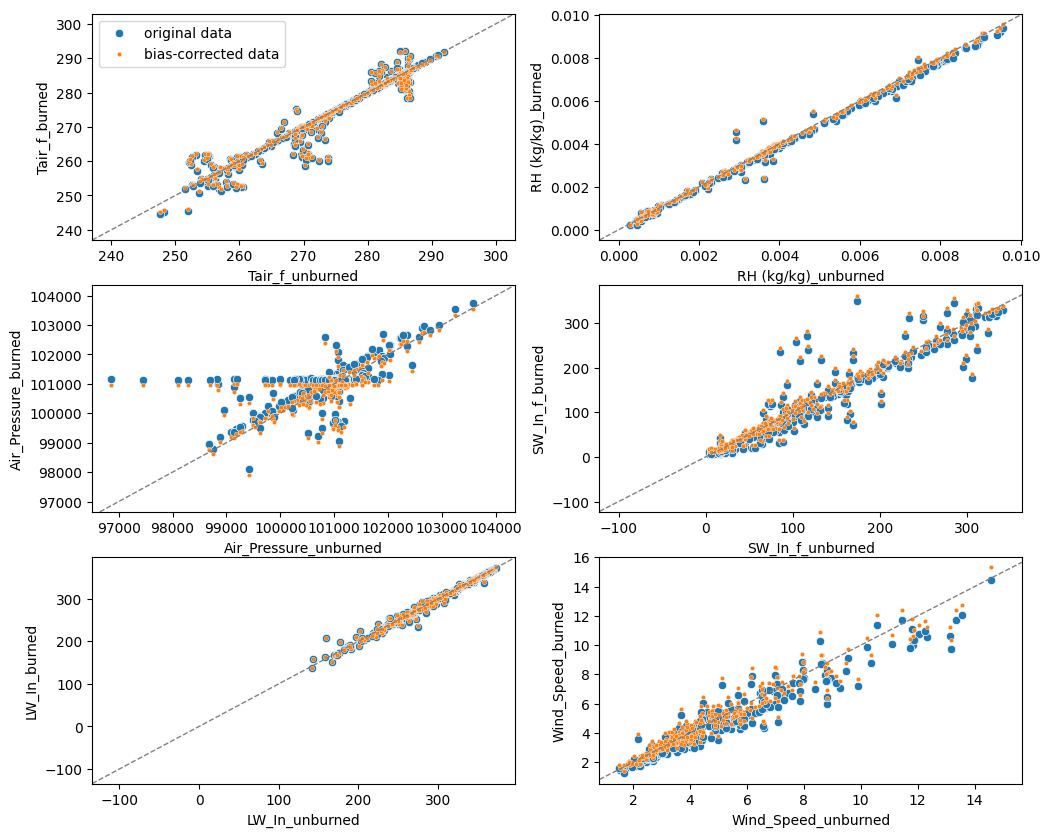

In [10]:
#plot relationship before and after bias correction

fig, axes=plt.subplots(3,2, figsize=(12,10))

axes[0,0].axline((240, 240), (300, 300), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='Tair_f_unburned', y='Tair_f_burned', ax=axes[0,0], label='original data')
sns.scatterplot(x=df_daily_merged['Tair_f_unburned'], y=df_daily_merged['Tair_f_burned']*b2u_reg_tair_coef+b2u_reg_tair_intercept, ax=axes[0,0],s=10, label='bias-corrected data')

axes[0,1].axline((0, 0), (0.001, 0.001), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='RH (kg/kg)_unburned', y='RH (kg/kg)_burned', ax=axes[0,1])
sns.scatterplot(x=df_daily_merged['RH (kg/kg)_unburned'], y=df_daily_merged['RH (kg/kg)_burned']*b2u_reg_rh_coef+b2u_reg_rh_intercept, ax=axes[0,1],s=10)

axes[1,0].axline((97000, 97000), (104000, 104000), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='Air_Pressure_unburned', y='Air_Pressure_burned', ax=axes[1,0])
sns.scatterplot(x=df_daily_merged['Air_Pressure_unburned'], y=df_daily_merged['Air_Pressure_burned']-b2u_air_press_median_adjust, ax=axes[1,0],s=10)


axes[1,1].axline((-100, -100), (260, 260), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='SW_In_f_unburned', y='SW_In_f_burned', ax=axes[1,1])
sns.scatterplot(x=df_daily_merged['SW_In_f_unburned'], y=df_daily_merged['SW_In_f_burned']*b2u_reg_sw_net_coef+b2u_reg_sw_net_intercept, ax=axes[1,1],s=10)

axes[2,0].axline((-110, -110), (10, 10), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='LW_In_unburned', y='LW_In_burned', ax=axes[2,0])
sns.scatterplot(x=df_daily_merged['LW_In_unburned'], y=df_daily_merged['LW_In_burned']*b2u_reg_lw_net_coef+b2u_reg_lw_net_intercept, ax=axes[2,0],s=10)

axes[2,1].axline((1.5, 1.5), (15, 15), linewidth=1, color='grey', linestyle='--')
sns.scatterplot(data=df_daily_merged, x='Wind_Speed_unburned', y='Wind_Speed_burned', ax=axes[2,1])
sns.scatterplot(x=df_daily_merged['Wind_Speed_unburned'], y=df_daily_merged['Wind_Speed_burned']*b2u_reg_wind_speed_coef+b2u_reg_wind_speed_intercept, ax=axes[2,1],s=10)

plt.savefig('YKD/figs/YKD_bias_correction.jpg', dpi=300)

In [11]:
#filled unburned dataset
df_unburned_filled=pd.DataFrame()
df_unburned_filled['datetime'] = df_daily_merged['datetime']
df_unburned_filled['Year'] = df_daily_merged['Year_unburned']
df_unburned_filled['Month'] = df_daily_merged['Month_unburned']
df_unburned_filled['Day'] = df_daily_merged['Day_unburned']
df_unburned_filled['Tair_f'] = df_daily_merged['Tair_f_unburned']
df_unburned_filled['RH'] = df_daily_merged['RH (kg/kg)_unburned']
df_unburned_filled['Air_Pressure'] = df_daily_merged['Air_Pressure_unburned']
df_unburned_filled['SW_In_f'] = df_daily_merged['SW_In_f_unburned']
df_unburned_filled['LW_In'] = df_daily_merged['LW_In_unburned']
df_unburned_filled['Wind_Speed'] = df_daily_merged['Wind_Speed_unburned']
df_unburned_filled['Wind_Dir'] = df_daily_merged['Wind_Dir_unburned']
df_unburned_filled['Precip_mm'] = df_daily_merged['Precip_mm_unburned']

#filled burned dataset
df_burned_filled=pd.DataFrame()
df_burned_filled['datetime'] = df_daily_merged['datetime']
df_burned_filled['Year'] = df_daily_merged['Year_burned']
df_burned_filled['Month'] = df_daily_merged['Month_burned']
df_burned_filled['Day'] = df_daily_merged['Day_burned']
df_burned_filled['Tair_f'] = df_daily_merged['Tair_f_burned']
df_burned_filled['RH'] = df_daily_merged['RH (kg/kg)_burned']
df_burned_filled['Air_Pressure'] = df_daily_merged['Air_Pressure_burned']
df_burned_filled['SW_In_f'] = df_daily_merged['SW_In_f_burned']
df_burned_filled['LW_In'] = df_daily_merged['LW_In_burned']
df_burned_filled['Wind_Speed'] = df_daily_merged['Wind_Speed_burned']
df_burned_filled['Wind_Dir'] = df_daily_merged['Wind_Dir_burned']
df_burned_filled['Precip_mm'] = df_daily_merged['Precip_mm_burned']

In [12]:
#fill unburned dataset
df_unburned_filled.loc[df_unburned_filled['RH'].isnull(),'RH'] = df_daily_merged.loc[df_daily_merged['RH (kg/kg)_unburned'].isnull(),'RH (kg/kg)_burned']*b2u_reg_rh_coef+b2u_reg_rh_intercept
df_unburned_filled['RH']=df_unburned_filled['RH'].interpolate()

df_unburned_filled.loc[df_unburned_filled['Air_Pressure'].isnull(),'Air_Pressure'] = df_daily_merged.loc[df_daily_merged['Air_Pressure_unburned'].isnull(),'Air_Pressure_burned']-b2u_air_press_median_adjust
df_unburned_filled['Air_Pressure']=df_unburned_filled['Air_Pressure'].interpolate()

df_unburned_filled.loc[df_unburned_filled['SW_In_f'].isnull(),'SW_In_f'] = df_daily_merged.loc[df_daily_merged['SW_In_f_unburned'].isnull(),'SW_In_f_burned']*b2u_reg_sw_net_coef+b2u_reg_sw_net_intercept
df_unburned_filled['SW_In_f']=df_unburned_filled['SW_In_f'].interpolate()

df_unburned_filled.loc[df_unburned_filled['LW_In'].isnull(),'LW_In'] = df_daily_merged.loc[df_daily_merged['LW_In_unburned'].isnull(),'LW_In_burned']*b2u_reg_lw_net_coef+b2u_reg_lw_net_intercept
df_unburned_filled['LW_In']=df_unburned_filled['LW_In'].interpolate()

df_unburned_filled.loc[df_unburned_filled['Wind_Speed'].isnull(),'Wind_Speed'] = df_daily_merged.loc[df_daily_merged['Wind_Speed_unburned'].isnull(),'Wind_Speed_burned']*b2u_reg_wind_speed_coef+b2u_reg_wind_speed_intercept
df_unburned_filled['Wind_Speed']=df_unburned_filled['Wind_Speed'].interpolate()

df_unburned_filled.loc[df_unburned_filled['Wind_Dir'].isnull(),'Wind_Dir'] = df_daily_merged.loc[df_daily_merged['Wind_Dir_unburned'].isnull(),'Wind_Dir_burned']
df_unburned_filled['Wind_Dir']=df_unburned_filled['Wind_Dir'].interpolate()

#fill burned dataset
df_burned_filled.loc[df_burned_filled['RH'].isnull(),'RH'] = df_daily_merged.loc[df_daily_merged['RH (kg/kg)_burned'].isnull(),'RH (kg/kg)_unburned']*u2b_reg_rh_coef+u2b_reg_rh_intercept
df_burned_filled['RH']=df_burned_filled['RH'].interpolate()

df_burned_filled.loc[df_burned_filled['Air_Pressure'].isnull(),'Air_Pressure'] = df_daily_merged.loc[df_daily_merged['Air_Pressure_burned'].isnull(),'Air_Pressure_unburned']-u2b_air_press_median_adjust
df_burned_filled['Air_Pressure']=df_burned_filled['Air_Pressure'].interpolate()

df_burned_filled.loc[df_burned_filled['SW_In_f'].isnull(),'SW_In_f'] = df_daily_merged.loc[df_daily_merged['SW_In_f_burned'].isnull(),'SW_In_f_unburned']*u2b_reg_sw_net_coef+u2b_reg_sw_net_intercept
df_burned_filled['SW_In_f']=df_burned_filled['SW_In_f'].interpolate()

df_burned_filled.loc[df_burned_filled['LW_In'].isnull(),'LW_In'] = df_daily_merged.loc[df_daily_merged['LW_In_burned'].isnull(),'LW_In_unburned']*u2b_reg_lw_net_coef+u2b_reg_lw_net_intercept
df_burned_filled['LW_In']=df_burned_filled['LW_In'].interpolate()

df_burned_filled.loc[df_burned_filled['Wind_Speed'].isnull(),'Wind_Speed'] = df_daily_merged.loc[df_daily_merged['Wind_Speed_burned'].isnull(),'Wind_Speed_unburned']*u2b_reg_wind_speed_coef+u2b_reg_wind_speed_intercept
df_burned_filled['Wind_Speed']=df_burned_filled['Wind_Speed'].interpolate()

df_burned_filled.loc[df_burned_filled['Wind_Dir'].isnull(),'Wind_Dir'] = df_daily_merged.loc[df_daily_merged['Wind_Dir_burned'].isnull(),'Wind_Dir_unburned']
df_burned_filled['Wind_Dir']=df_burned_filled['Wind_Dir'].interpolate()

df_unburned_filled.loc[df_unburned_filled['Precip_mm'].isnull(),'Precip_mm'] = 0
df_burned_filled.loc[df_burned_filled['Precip_mm'].isnull(),'Precip_mm'] = 0
df_burned_filled.loc[df_burned_filled['Precip_mm']==0,'Precip_mm'] = df_unburned_filled.loc[df_burned_filled['Precip_mm']==0,'Precip_mm']
df_unburned_filled.loc[df_unburned_filled['Precip_mm']==0,'Precip_mm'] = df_burned_filled.loc[df_unburned_filled['Precip_mm']==0,'Precip_mm']

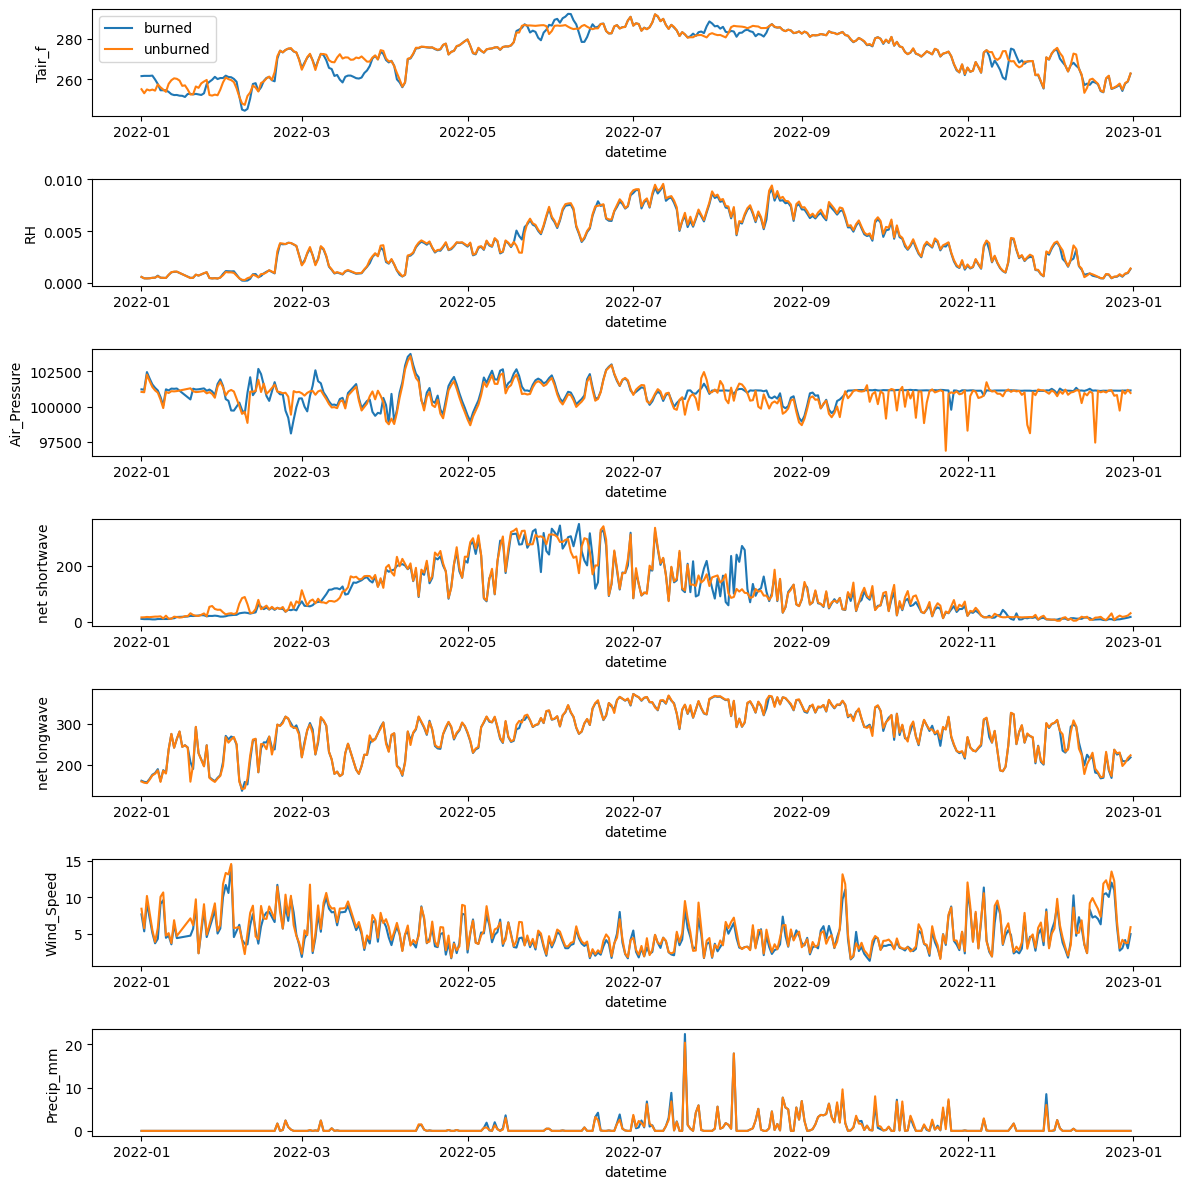

In [13]:
#plot gap-filled dataset
fig, axes=plt.subplots(7,1, figsize=(12,12))

sns.lineplot(data=df_burned_filled, x='datetime', y='Tair_f', ax=axes[0], label='burned')
sns.lineplot(data=df_unburned_filled, x='datetime', y='Tair_f', ax=axes[0], label='unburned')

sns.lineplot(data=df_burned_filled, x='datetime', y='RH', ax=axes[1])
sns.lineplot(data=df_unburned_filled, x='datetime', y='RH', ax=axes[1])

sns.lineplot(data=df_burned_filled, x='datetime', y='Air_Pressure', ax=axes[2])
sns.lineplot(data=df_unburned_filled, x='datetime', y='Air_Pressure', ax=axes[2])

sns.lineplot(data=df_burned_filled, x='datetime', y=df_burned_filled['SW_In_f'], ax=axes[3])
sns.lineplot(data=df_unburned_filled, x='datetime', y=df_unburned_filled['SW_In_f'], ax=axes[3])
axes[3].set_ylabel('net shortwave')

sns.lineplot(data=df_burned_filled, x='datetime', y=df_burned_filled['LW_In'], ax=axes[4])
sns.lineplot(data=df_unburned_filled, x='datetime', y=df_unburned_filled['LW_In'], ax=axes[4])
axes[4].set_ylabel('net longwave')

sns.lineplot(data=df_burned_filled, x='datetime', y='Wind_Speed', ax=axes[5])
sns.lineplot(data=df_unburned_filled, x='datetime', y='Wind_Speed', ax=axes[5])

sns.lineplot(data=df_burned_filled, x='datetime', y='Precip_mm', ax=axes[6])
sns.lineplot(data=df_unburned_filled, x='datetime', y='Precip_mm', ax=axes[6])

fig.tight_layout()

# Check for nans in inputs

In [14]:
len(df_unburned_filled)

365

In [15]:
len(df_unburned_filled.dropna(axis=0))

365

In [16]:
len(df_burned_filled)

365

In [17]:
len(df_burned_filled.dropna(axis=0))

365

# Add snow information

In [18]:
#No available snow observations at the site, so we will scale data from McGrath SNOTEL site
snotel_path= 'YKD/in_situ/McGrath_SNOTEL_2022.csv'
snow_df=pd.read_csv(snotel_path,skiprows=4)
snow_df=snow_df.rename(columns={'Date': 'datetime'})
snow_df['datetime'] = pd.to_datetime(snow_df['datetime'])
snow_df.columns

snow_df['WTEQ.I-1 (in) '] = snow_df['WTEQ.I-1 (in) ']/2 #We need to reduce SWE since the met obs are coming from a site with deeper snowpack

snow_df['SWE (mm)'] = snow_df['WTEQ.I-1 (in) '] * 25.4 #in to mm
snow_df.loc[snow_df['SWE (mm)']<0, 'SWE (mm)']=0 #filter negative SWE
snow_df=snow_df[['datetime', 'SWE (mm)']]
snow_df=snow_df.sort_values(by='datetime')
snow_df['SWE_diff'] = snow_df['SWE (mm)'].diff() #calculate change in SWE
snow_df.loc[0, 'SWE_diff'] = 0 #set initial change in SWE to zero
snow_df['SWE_accum'] = 0
snow_df.loc[snow_df['SWE_diff']>0, 'SWE_accum'] = snow_df['SWE_diff'] #filter out negative change in SWE

<Axes: xlabel='datetime', ylabel='SWE_accum'>

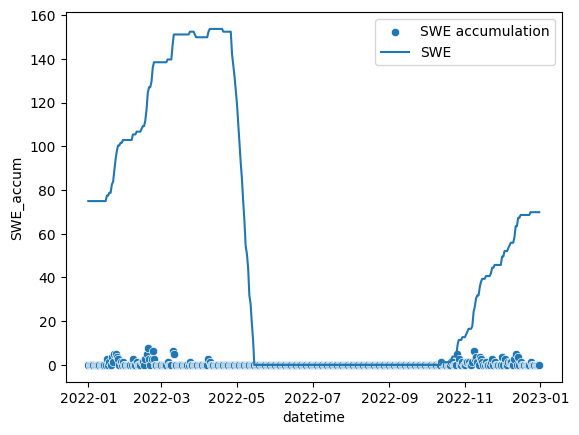

In [19]:
#plot observed SWE (in) vs SWE accumulation (mm/d)
sns.scatterplot(data=snow_df, x='datetime', y='SWE_accum', label='SWE accumulation')
sns.lineplot(data=snow_df, x='datetime', y='SWE (mm)', label='SWE')

In [20]:
#merge SWE accumulation
df_unburned_filled = df_unburned_filled.merge(snow_df[['datetime', 'SWE_accum']], on='datetime')
df_burned_filled = df_burned_filled.merge(snow_df[['datetime', 'SWE_accum']], on='datetime')

#add SWE to precip (liquid)
df_unburned_filled['Precip_mm'] = df_unburned_filled['Precip_mm']+df_unburned_filled['SWE_accum']
df_burned_filled['Precip_mm'] = df_burned_filled['Precip_mm']+df_burned_filled['SWE_accum']

#convert precip (mm/day) to (m/s)
df_unburned_filled['Precip_intensity_ms-1'] = (df_unburned_filled['Precip_mm']/1000)/86400
df_burned_filled['Precip_intensity_ms-1'] = (df_burned_filled['Precip_mm']/1000)/86400

# Smooth variables

In [21]:
def smooth_timeseries(df,w):
    df1=df.copy()
    df1["Tair_f"] = scipy.signal.savgol_filter(df1["Tair_f"], w, 2, mode='wrap')
    df1["LW_In"] = scipy.signal.savgol_filter(df1["LW_In"], w, 2, mode='wrap')
    df1["SW_In_f"] = scipy.signal.savgol_filter(df1["SW_In_f"], w, 2, mode='wrap')
    df1["Wind_Speed"] = scipy.signal.savgol_filter(df1["Wind_Speed"], w, 2, mode='wrap')
    df1["Air_Pressure"] = scipy.signal.medfilt(df1["Air_Pressure"], 3)
    #m_precip_rain = df1["rain [m/s]"].mean()
    #m_precip_snow = df1["snow [m/s]"].mean()
    #snow = np.where(df1["Temp [K]"] < 273.15, m_precip_snow, 0)
    #rain = np.where(df1["Temp [K]"] >= 273.15, m_precip_rain, 0)
    #df1["rain [m/s]"] = rain
    #df1["snow [m/s]"] = snow

    return df1

In [22]:
#light smoothing to observed meteorology
df_unburned_filled=smooth_timeseries(df_unburned_filled, 5)
df_burned_filled=smooth_timeseries(df_burned_filled, 5)

# Split wind speed into U and V components

In [23]:
pi_180= np.pi/180

df_unburned_filled.loc[df_unburned_filled['Wind_Dir']==360, 'Wind_Dir'] = 0
df_burned_filled.loc[df_burned_filled['Wind_Dir']==360, 'Wind_Dir'] = 0

df_unburned_filled['Wind_Speed_u'] = -df_unburned_filled['Wind_Speed']*np.cos(df_unburned_filled['Wind_Dir']*pi_180)
df_unburned_filled['Wind_Speed_v'] = -df_unburned_filled['Wind_Speed']*np.sin(df_unburned_filled['Wind_Dir']*pi_180)

df_burned_filled['Wind_Speed_u'] = -df_burned_filled['Wind_Speed']*np.cos(df_burned_filled['Wind_Dir']*pi_180)
df_burned_filled['Wind_Speed_v'] = -df_burned_filled['Wind_Speed']*np.sin(df_burned_filled['Wind_Dir']*pi_180)

df_unburned_filled.loc[df_unburned_filled['Wind_Speed_u'].abs()<0.1, 'Wind_Speed_u'] = 0
df_unburned_filled.loc[df_unburned_filled['Wind_Speed_v'].abs()<0.1, 'Wind_Speed_u'] = 0

df_burned_filled.loc[df_burned_filled['Wind_Speed_u'].abs()<0.1, 'Wind_Speed_u'] = 0
df_burned_filled.loc[df_burned_filled['Wind_Speed_v'].abs()<0.1, 'Wind_Speed_u'] = 0

# Plot final data, format for LAKE input

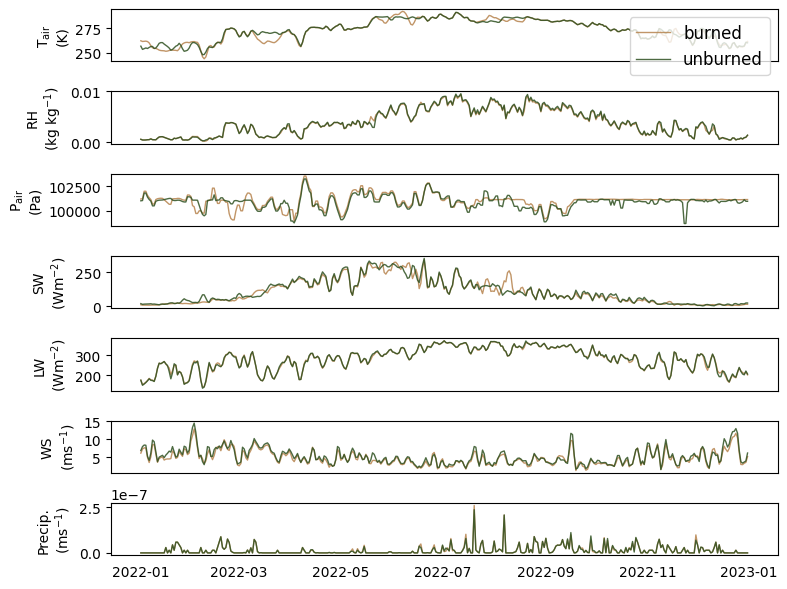

In [24]:
sns.set_palette(sns.color_palette(['#B6834D', '#2E5020']))

fig, axes=plt.subplots(7,1, figsize=(8,6), sharex=True)

sns.lineplot(data=df_burned_filled, x='datetime', y='Tair_f', ax=axes[0], label='burned', alpha=0.85, linewidth=1)
sns.lineplot(data=df_unburned_filled, x='datetime', y='Tair_f', ax=axes[0], label='unburned', alpha=0.85, linewidth=1)
axes[0].set_ylabel('$\mathregular{T_{air}}$\n(K)')
axes[0].tick_params(axis='x', which='both', bottom=False)

sns.lineplot(data=df_burned_filled, x='datetime', y='RH', ax=axes[1], alpha=0.85, linewidth=1)
sns.lineplot(data=df_unburned_filled, x='datetime', y='RH', ax=axes[1], alpha=0.85, linewidth=1)
axes[1].set_ylabel('RH\n(kg $\mathregular{kg^{-1}}$)')
axes[1].tick_params(axis='x', which='both', bottom=False)

sns.lineplot(data=df_burned_filled, x='datetime', y='Air_Pressure', ax=axes[2], alpha=0.85, linewidth=1)
sns.lineplot(data=df_unburned_filled, x='datetime', y='Air_Pressure', ax=axes[2], alpha=0.85, linewidth=1)
axes[2].set_ylabel('$\mathregular{P_{air}}$\n(Pa)')
axes[2].tick_params(axis='x', which='both', bottom=False)

sns.lineplot(data=df_burned_filled, x='datetime', y='SW_In_f', ax=axes[3], alpha=0.85, linewidth=1)
sns.lineplot(data=df_unburned_filled, x='datetime', y='SW_In_f', ax=axes[3], alpha=0.85, linewidth=1)
axes[3].set_ylabel('SW\n(W$\mathregular{m^{-2}}$)')
axes[3].tick_params(axis='x', which='both', bottom=False)

sns.lineplot(data=df_burned_filled, x='datetime', y='LW_In', ax=axes[4], alpha=0.85, linewidth=1)
sns.lineplot(data=df_unburned_filled, x='datetime', y='LW_In', ax=axes[4], alpha=0.85, linewidth=1)
axes[4].set_ylabel('LW\n(W$\mathregular{m^{-2}}$)')
axes[4].tick_params(axis='x', which='both', bottom=False)

sns.lineplot(data=df_burned_filled, x='datetime', y='Wind_Speed', ax=axes[5], alpha=0.85, linewidth=1)
sns.lineplot(data=df_unburned_filled, x='datetime', y='Wind_Speed', ax=axes[5], alpha=0.85, linewidth=1)
axes[5].set_ylabel('WS\n(m$\mathregular{s^{-1}}$)')
axes[5].tick_params(axis='x', which='both', bottom=False)

sns.lineplot(data=df_burned_filled, x='datetime', y='Precip_intensity_ms-1', ax=axes[6], alpha=0.85, linewidth=1)
sns.lineplot(data=df_unburned_filled, x='datetime', y='Precip_intensity_ms-1', ax=axes[6], alpha=0.85, linewidth=1)
axes[6].set_ylabel('Precip.\n(m$\mathregular{s^{-1}}$)')
axes[6].tick_params(axis='x', which='both', bottom=False)
plt.xlabel('')

leg = axes[0].legend(fontsize=12, loc='upper right')
fig.tight_layout()
plt.savefig('YKD/figs/LAKE_ins_YKD_2022.jpg', dpi=300)

### LAKE Parameters again for reference

* N_header_lines* --- the number of lines, occupied by file header 
* N_coloumns*     --- the total number of coloumns in the file
* N_Year*         --- the number of coloumn with the number of year (not used in the model)
* N_Month*        --- the number of coloumn with the number of month (not used in the model)
* N_Day*          --- the number of coloumn with the number of day (not used in the model)
* N_Hour*         --- the number of coloumn with the number of hour (not used in the model)
* N_Uspeed*       --- the number of coloumn with x-component speed values,      (m/s)
* N_Vspeed*       --- the number of coloumn with y-component speed values,      (m/s)
* N_Temp*         --- the number of coloumn with air temperature values,        (K)
* N_Hum*          --- the number of coloumn with air humidity values,           (kg/kg)
* N_Pres*         --- the number of coloumn with atmospheric pressure value,s   (Pa)
* N_SWdown*       --- the number of coloumn with net solar radiation values,    (W/m**2)
* N_LWdown*       --- the number of coloumn with net longwave radiation values, (W/m**2)
* N_Precip*       --- the number of coloumn with precipitation intensity,       (m/s)

In [25]:
#select required variables and rename

df_burned_out=df_burned_filled[['Year', 'Month', 'Day', 'Wind_Speed_u', 'Wind_Speed_v',
                                'Tair_f', 'RH', 'Air_Pressure', 'SW_In_f', 'LW_In', 'Precip_intensity_ms-1']]
df_burned_out.columns=['Year','Month','Day','Uspeed','Vspeed','Temp','Hum','Pres','SWdown','LWdown','Precip']

df_unburned_out=df_unburned_filled[['Year', 'Month', 'Day', 'Wind_Speed_u', 'Wind_Speed_v',
                                'Tair_f', 'RH', 'Air_Pressure', 'SW_In_f', 'LW_In', 'Precip_intensity_ms-1']]
df_unburned_out.columns=['Year','Month','Day','Uspeed','Vspeed','Temp','Hum','Pres','SWdown','LWdown','Precip']

#Save to .dat file
df_unburned_out.to_csv('YKD/LAKE/base_case/YKD-unburned.dat', index=False)
df_burned_out.to_csv('YKD/LAKE/base_case/YKD-burned.dat', index=False)

In [26]:
#create data files that start July 1, 2021 and run through December 31, 2022

df_unburned_july_h1 = df_unburned_out.loc[df_unburned_out['Month']>=7]
df_unburned_july_h2 = df_unburned_out.loc[df_unburned_out['Month']<7]

df_unburned_july_start = pd.concat([df_unburned_july_h1, df_unburned_july_h2, df_unburned_july_h1], ignore_index=True)

df_unburned_july_start['datetime'] =pd.date_range(start='2021-07-01', end='2022-12-31')
df_unburned_july_start['Year'] = df_unburned_july_start['datetime'].dt.year
df_unburned_july_start['Month'] = df_unburned_july_start['datetime'].dt.month
df_unburned_july_start['Day'] = df_unburned_july_start['datetime'].dt.day

df_burned_july_h1 = df_burned_out.loc[df_burned_out['Month']>=7]
df_burned_july_h2 = df_burned_out.loc[df_burned_out['Month']<7]

df_burned_july_start = pd.concat([df_burned_july_h1, df_burned_july_h2, df_burned_july_h1], ignore_index=True)

df_burned_july_start['datetime'] =pd.date_range(start='2021-07-01', end='2022-12-31')
df_burned_july_start['Year'] = df_burned_july_start['datetime'].dt.year
df_burned_july_start['Month'] = df_burned_july_start['datetime'].dt.month
df_burned_july_start['Day'] = df_burned_july_start['datetime'].dt.day

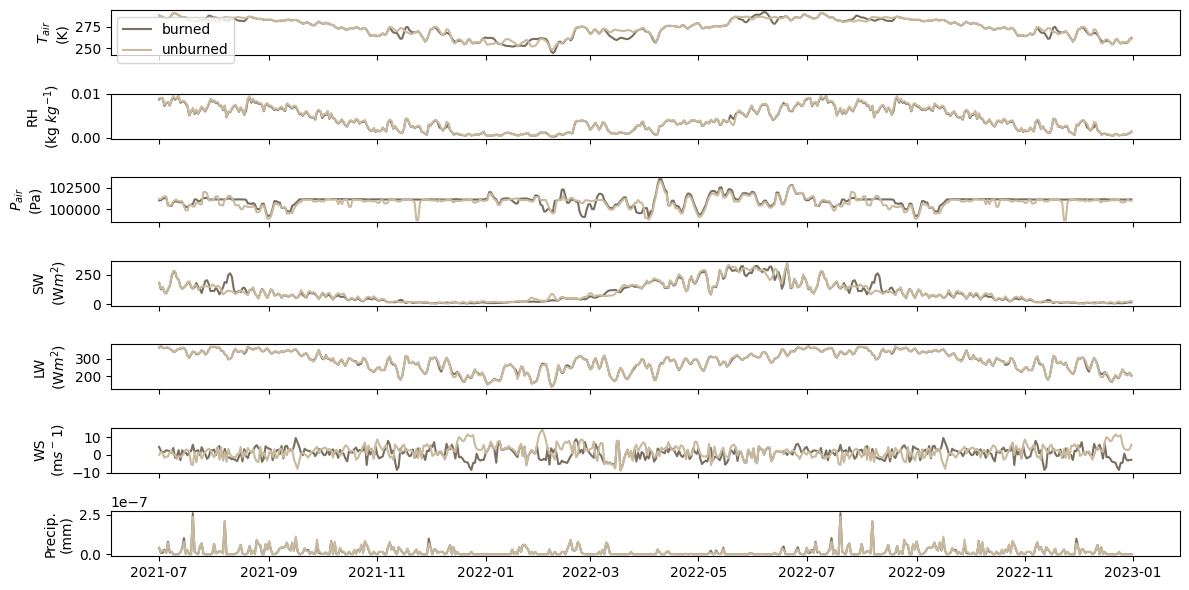

In [27]:
#plot july start data
sns.set_palette(sns.color_palette(['#786F5F', '#C9BA9F']))

fig, axes=plt.subplots(7,1, figsize=(12,6), sharex=True)

sns.lineplot(data=df_burned_july_start, x='datetime', y='Temp', ax=axes[0], label='burned')
sns.lineplot(data=df_unburned_july_start, x='datetime', y='Temp', ax=axes[0], label='unburned')
axes[0].set_ylabel('$T_{air}$\n(K)')

sns.lineplot(data=df_burned_july_start, x='datetime', y='Hum', ax=axes[1])
sns.lineplot(data=df_unburned_july_start, x='datetime', y='Hum', ax=axes[1])
axes[1].set_ylabel('RH\n(kg $kg^{-1}$)')

sns.lineplot(data=df_burned_july_start, x='datetime', y='Pres', ax=axes[2])
sns.lineplot(data=df_unburned_july_start, x='datetime', y='Pres', ax=axes[2])
axes[2].set_ylabel('$P_{air}$\n(Pa)')

sns.lineplot(data=df_burned_july_start, x='datetime', y='SWdown', ax=axes[3])
sns.lineplot(data=df_unburned_july_start, x='datetime', y='SWdown', ax=axes[3])
axes[3].set_ylabel('SW\n(W$m^2$)')

sns.lineplot(data=df_burned_july_start, x='datetime', y='LWdown', ax=axes[4])
sns.lineplot(data=df_unburned_july_start, x='datetime', y='LWdown', ax=axes[4])
axes[4].set_ylabel('LW\n(W$m^2$)')

sns.lineplot(data=df_burned_july_start, x='datetime', y='Uspeed', ax=axes[5])
sns.lineplot(data=df_unburned_july_start, x='datetime', y='Uspeed', ax=axes[5])
axes[5].set_ylabel('WS\n(m$s^-1$)')

sns.lineplot(data=df_burned_july_start, x='datetime', y='Precip', ax=axes[6])
sns.lineplot(data=df_unburned_july_start, x='datetime', y='Precip', ax=axes[6])
axes[6].set_ylabel('Precip.\n(mm)')
plt.xlabel('')

fig.tight_layout()
plt.savefig('YKD/figs/YKD_july-start.jpg', dpi=300)

In [28]:
df_unburned_july_start.to_csv('YKD/LAKE/base_case/YKD-unburned-july-start.dat', index=False)
df_burned_july_start.to_csv('YKD/LAKE/base_case/YKD-burned-july-start.dat', index=False)

# Spinup dataset

In [29]:
# We will set up spinup to start Oct. 1 and run for 40 years

# Unburned
# select Oct 1. - Dec. 31
df_unburned_spinup_h1 = df_unburned_out.loc[df_unburned_out['Month']>=10]
# select Jan 1. - Sept. 30
df_unburned_spinup_h2 = df_unburned_out.loc[df_unburned_out['Month']<10]

# rearrange data
df_unburned_spinup = pd.concat([df_unburned_spinup_h1,df_unburned_spinup_h2])

# repeat for 40 years
df_unburned_spinup = pd.concat([df_unburned_spinup]*40, ignore_index=True)

# create date range
daterange=pd.date_range(start='1975-10-01', end='2015-09-30')
print(len(df_unburned_spinup))

# exclude leap days
df_unburned_spinup['datetime'] = daterange[(daterange.month != 2) | (daterange.day != 29)] 
print(len(df_unburned_spinup))

14600
14600


In [30]:
# Burned
# select Oct 1. - Dec. 31
df_burned_spinup_h1 = df_burned_out.loc[df_burned_out['Month']>=10]
# select Jan 1. - Sept. 30
df_burned_spinup_h2 = df_burned_out.loc[df_burned_out['Month']<10]

# rearrange data
df_burned_spinup = pd.concat([df_burned_spinup_h1,df_burned_spinup_h2])

# repeat for 40 years
df_burned_spinup = pd.concat([df_burned_spinup]*40, ignore_index=True)

# create date range
daterange=pd.date_range(start='1975-10-01', end='2015-09-30')

# exclude leap days
df_burned_spinup['datetime'] = daterange[(daterange.month != 2) | (daterange.day != 29)] 

In [31]:
def smooth_spinup(df,w):
    #Apply smoothing to spinup data
    df1=df.copy()
    df1["Temp"] = scipy.signal.savgol_filter(df1["Temp"], w, 2, mode='wrap')
    df1["LWdown"] = scipy.signal.savgol_filter(df1["LWdown"], w, 2, mode='wrap')
    df1["SWdown"] = scipy.signal.savgol_filter(df1["SWdown"], w, 2, mode='wrap')
    df1["Uspeed"] = scipy.signal.savgol_filter(df1["Uspeed"], w, 2, mode='wrap')
    df1["Vspeed"] = scipy.signal.savgol_filter(df1["Vspeed"], w, 2, mode='wrap')
    df1["Hum"] = scipy.signal.savgol_filter(df1["Hum"], w, 2, mode='wrap')
    df1["Pres"] = scipy.signal.medfilt(df1["Pres"], w)

    #constant precipitation of mean value for rain and snow
    df1.loc[df1["Temp"] >= 273.15,"Precip"] = df1.loc[df1["Temp"] >= 273.15,"Precip"].mean()
    df1.loc[df1["Temp"] < 273.15,"Precip"] = df1.loc[df1["Temp"] < 273.15,"Precip"].mean()

    return df1

In [32]:
# smooth data for spinup
df_unburned_spinup_smoothed=smooth_spinup(df_unburned_spinup,25)
df_burned_spinup_smoothed=smooth_spinup(df_burned_spinup,25)

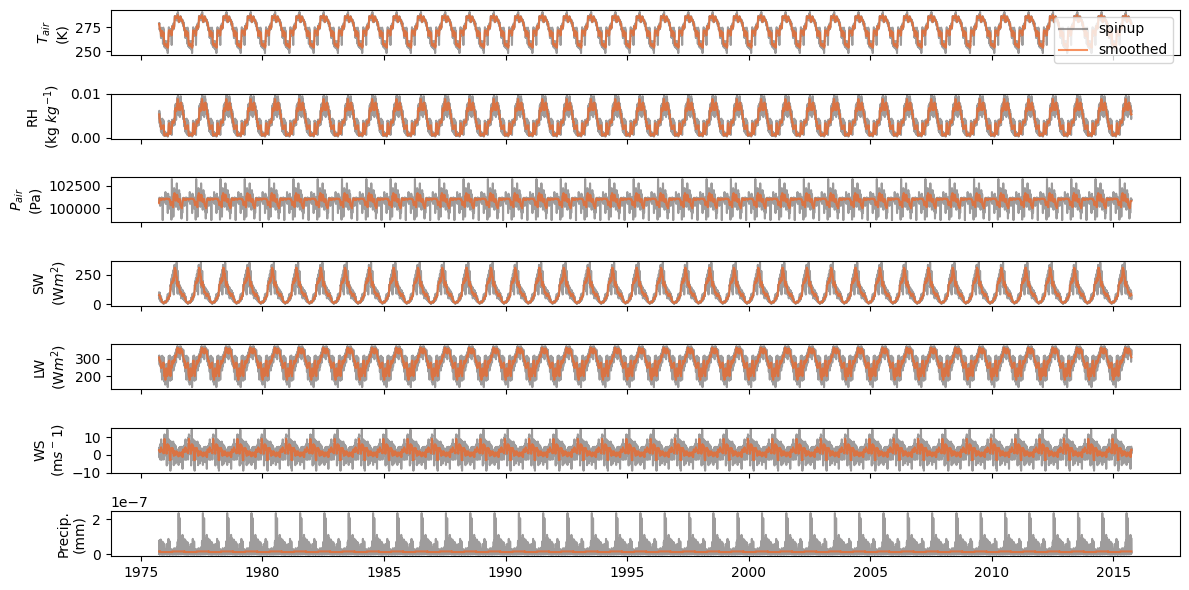

In [33]:
# Plot spinup data for unburned, smoothed vs not smoothed

sns.set_palette(sns.color_palette(['#757373', '#f5621d']))

fig, axes=plt.subplots(7,1, figsize=(12,6), sharex=True)

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Temp', ax=axes[0], label='spinup', alpha=0.7)
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Temp', ax=axes[0], label='smoothed', alpha=0.7)
axes[0].set_ylabel('$T_{air}$\n(K)')

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Hum', ax=axes[1], alpha=0.7)
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Hum', ax=axes[1], alpha=0.7)
axes[1].set_ylabel('RH\n(kg $kg^{-1}$)')

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Pres', ax=axes[2], alpha=0.7)
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Pres', ax=axes[2], alpha=0.7)
axes[2].set_ylabel('$P_{air}$\n(Pa)')

sns.lineplot(data=df_unburned_spinup, x='datetime', y=df_unburned_spinup['SWdown'], ax=axes[3], alpha=0.7)
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y=df_unburned_spinup_smoothed['SWdown'], ax=axes[3], alpha=0.7)
axes[3].set_ylabel('SW\n(W$m^2$)')

sns.lineplot(data=df_unburned_spinup, x='datetime', y=df_unburned_spinup['LWdown'], ax=axes[4], alpha=0.7)
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y=df_unburned_spinup_smoothed['LWdown'], ax=axes[4], alpha=0.7)
axes[4].set_ylabel('LW\n(W$m^2$)')

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Uspeed', ax=axes[5], alpha=0.7)
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Uspeed', ax=axes[5], alpha=0.7)
axes[5].set_ylabel('WS\n(m$s^-1$)')

sns.lineplot(data=df_unburned_spinup, x='datetime', y='Precip', ax=axes[6], alpha=0.7)
sns.lineplot(data=df_unburned_spinup_smoothed, x='datetime', y='Precip', ax=axes[6], alpha=0.7)
axes[6].set_ylabel('Precip.\n(mm)')

plt.xlabel('')
fig.tight_layout()
plt.savefig('YKD/figs/YKD_unburned_spinup.jpg', dpi=300)

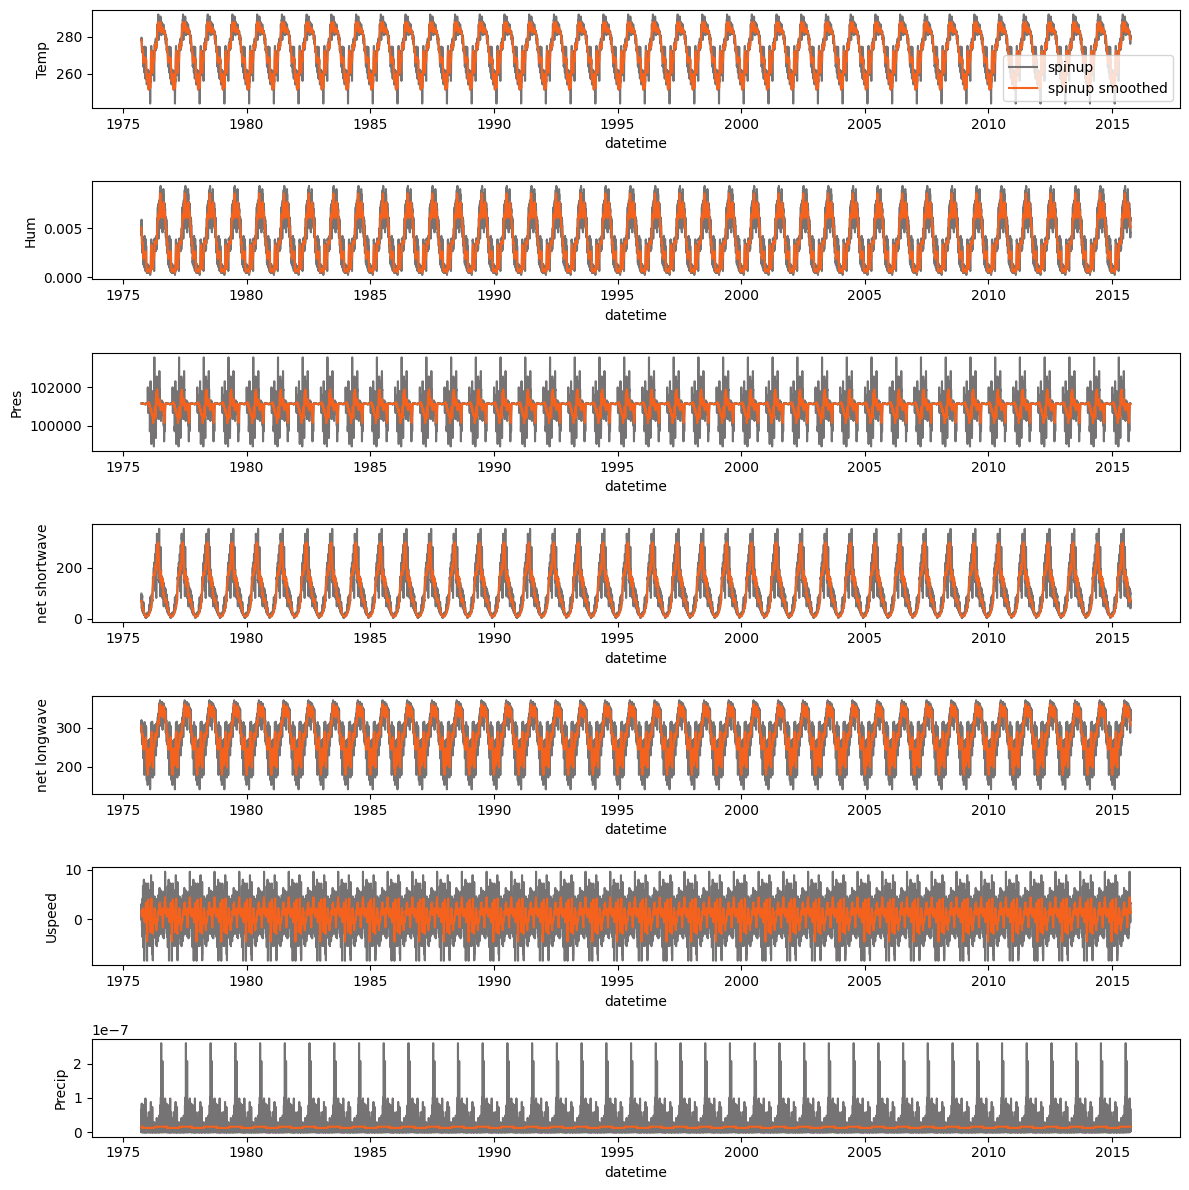

In [34]:
# Plot spinup data for burned, smoothed vs not smoothed

fig, axes=plt.subplots(7,1, figsize=(12,12))

sns.lineplot(data=df_burned_spinup, x='datetime', y='Temp', ax=axes[0], label='spinup')
sns.lineplot(data=df_burned_spinup_smoothed, x='datetime', y='Temp', ax=axes[0], label='spinup smoothed')

sns.lineplot(data=df_burned_spinup, x='datetime', y='Hum', ax=axes[1])
sns.lineplot(data=df_burned_spinup_smoothed, x='datetime', y='Hum', ax=axes[1])

sns.lineplot(data=df_burned_spinup, x='datetime', y='Pres', ax=axes[2])
sns.lineplot(data=df_burned_spinup_smoothed, x='datetime', y='Pres', ax=axes[2])

sns.lineplot(data=df_burned_spinup, x='datetime', y=df_unburned_spinup['SWdown'], ax=axes[3])
sns.lineplot(data=df_burned_spinup_smoothed, x='datetime', y=df_burned_spinup_smoothed['SWdown'], ax=axes[3])
axes[3].set_ylabel('net shortwave')

sns.lineplot(data=df_burned_spinup, x='datetime', y=df_burned_spinup['LWdown'], ax=axes[4])
sns.lineplot(data=df_burned_spinup_smoothed, x='datetime', y=df_burned_spinup_smoothed['LWdown'], ax=axes[4])
axes[4].set_ylabel('net longwave')

sns.lineplot(data=df_burned_spinup, x='datetime', y='Uspeed', ax=axes[5])
sns.lineplot(data=df_burned_spinup_smoothed, x='datetime', y='Uspeed', ax=axes[5])

sns.lineplot(data=df_burned_spinup, x='datetime', y='Precip', ax=axes[6])
sns.lineplot(data=df_burned_spinup_smoothed, x='datetime', y='Precip', ax=axes[6])

fig.tight_layout()
plt.savefig('YKD/figs/YKD_burned_spinup.jpg', dpi=300)

In [35]:
# save to .dat
df_unburned_spinup_smoothed.drop(columns=['datetime']).to_csv('YKD/LAKE/spinup/YKD-unburned-spinup.dat', index=False)
df_burned_spinup_smoothed.drop(columns=['datetime']).to_csv('YKD/LAKE/spinup/YKD-burned-spinup.dat', index=False)